In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model

model = load_model('./model/model_numeros_cnn.keras')

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()

    if not ret:
        break

    H, W, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            cantidad_manos = len(results.multi_hand_landmarks)
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        # Asegúrate de que data_aux tenga la forma correcta
        if cantidad_manos == 1 and len(data_aux) == 42:  # 21 puntos * 2 dimensiones
            data_aux_reshaped = np.asarray(data_aux).reshape(1, 21, 2)  # Cambiar la forma a (1, 21, 2)
            probabilities = model.predict(data_aux_reshaped)[0]

            if np.max(probabilities) > 0.8:
                predicted_character = np.argmax(probabilities)
            else:
                predicted_character = "undetected"
        else:
            predicted_character = "forbidden"

        # Dibujar el rectángulo y el texto en el cuadro
        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10
        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10

        predicted_character = str(predicted_character)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
        cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


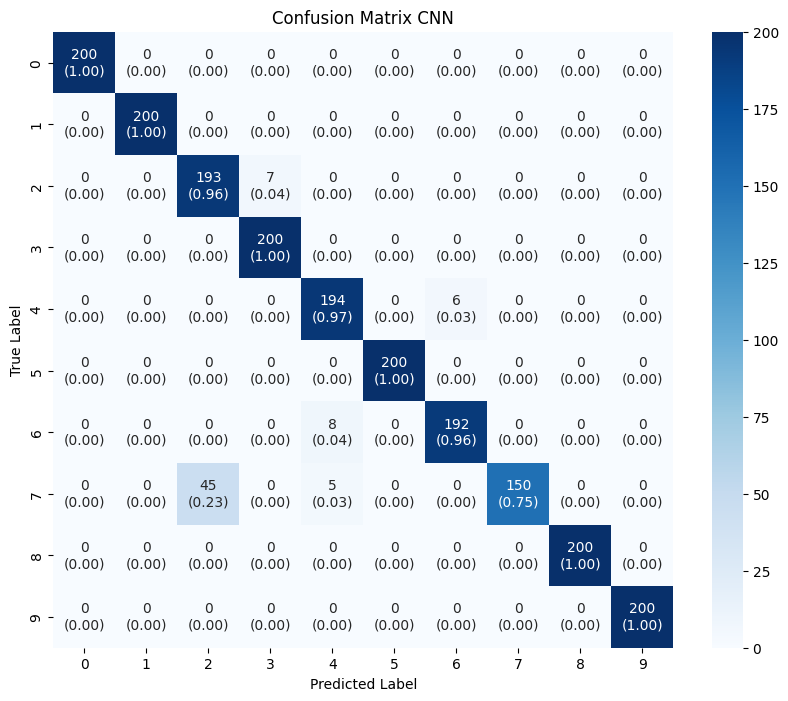

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       0.81      0.96      0.88       200
           3       0.97      1.00      0.98       200
           4       0.94      0.97      0.95       200
           5       1.00      1.00      1.00       200
           6       0.97      0.96      0.96       200
           7       1.00      0.75      0.86       200
           8       1.00      1.00      1.00       200
           9       1.00      1.00      1.00       200

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000



In [1]:
import pickle
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo guardado en formato .h5
model = load_model('model/model_numeros_cnn.keras')

# Diccionario para mapear índices a números
index_to_number = {i: str(i) for i in range(10)}

# Cargar los datos de prueba desde el archivo .pickle
data_dict = pickle.load(open('data/data_numeros_test.pickle', 'rb'))

# Convertir los datos y etiquetas a arrays de numpy
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Ajustar la forma de los datos para la CNN (21 puntos, cada uno con coordenadas x, y)
data = data.reshape(-1, 21, 2)

# Convertir etiquetas de texto a números usando LabelEncoder
label_encoder = LabelEncoder()
y_true_classes = label_encoder.fit_transform(labels)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(data)

# Convertir predicciones a clases (etiquetas) si es necesario
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred.astype(int)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Crear la matriz combinada
combined_matrix = np.zeros_like(conf_matrix, dtype=np.float32).astype(str)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        combined_matrix[i, j] = f"{conf_matrix[i, j]}\n({conf_matrix_normalized[i, j]:.2f})"

# Configuración de la visualización de la matriz combinada
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=combined_matrix, fmt='', cmap='Blues', xticklabels=index_to_number.values(), yticklabels=index_to_number.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN')
plt.show()

# Reporte de Clasificación
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=index_to_number.values()))